In [27]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [28]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [29]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [30]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [31]:
# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(engine, reflect=True)

In [32]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [33]:
# Save references to each table

Station = Base.classes.station
Measurement = Base.classes.measurement

In [34]:
# Create our session (link) from Python to the DB

session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [35]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [36]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

data2018 = calc_temps('2018-01-01', '2018-12-31')
print(data2016)
tmin = data2016[0][0]
tavg = data2016[0][1]
tmax = data2016[0][2]
print(f"Minimum temperature: {tmin},\n"
      f"Average temperature: {round(tavg, 1)},\n"
      f"Maximum temperature: {tmax}."
     )

[(56.0, 74.14421827631008, 84.0)]
Minimum temperature: 56.0,
Average temperature: 74.1,
Maximum temperature: 84.0.


Text(0, 0.5, 'Temperature (°F)')

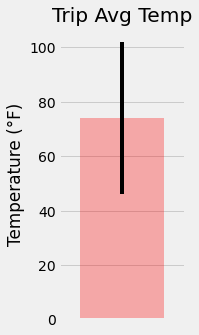

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(2,5))
plt.bar(0, tavg, width=0.4, color='r', alpha=0.3)
plt.errorbar(0, tavg, yerr = tmax - tmin, color='k')
plt.title('Trip Avg Temp')
plt.xticks([])
plt.xlim(-0.3, 0.3)
plt.ylabel('Temperature (°F)')

### Daily Rainfall Average

In [38]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-08-01'
end_date = '2017-08-07'

start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
previous_start_year = start_date.year - 1
start_date = start_date.replace(year=previous_start_year).date()

end_date = dt.datetime.strptime(end_date, '%Y-%m-%d')
previous_start_end = end_date.year - 1
end_date = end_date.replace(year=previous_start_end).date()

# Filter out the precipitation measurement throughout the target dates
sel = [Station.station, Station.name, Station.latitude,Station.longitude, 
       Station.elevation, func.round(func.sum(Measurement.prcp),2)]
queries = session.query(*sel).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        group_by(Station.station).order_by(func.sum(Measurement.prcp).desc())

# Create a dataframe to illustrate the information
name_list = ["Station", "Name", "Latitude", "Longitude", "Elevation", "Precipitation"]
rainfall_list = []

for query in queries:
    rainfall_dict = {}
    for i in range(len(query)):
        rainfall_dict[name_list[i]] = query[i]
    rainfall_list.append(rainfall_dict)

rainfall_df = pd.DataFrame(rainfall_list)
rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Precipitation
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,6.02
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.65
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,3.59
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,1.30
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.03
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.57
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.18


In [39]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [40]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
start = dt.datetime.strptime(start_date, '%Y-%m-%d')
end = dt.datetime.strptime(end_date, '%Y-%m-%d')
days = (end - start).days
date_list = [start + dt.timedelta(days=x) for x in range(days+1)]
date_list
# Strip off the year and save a list of strings in the format %m-%d
month_date_list = [date.strftime('%m-%d') for date in date_list]
month_date_list

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []

for i in range(len(month_date_list)):
    tup = {}
    tup['date'] = month_date_list[i]
    tup['tmin'] = daily_normals(month_date_list[i])[0][0]
    tup['tavg'] = daily_normals(month_date_list[i])[0][1]
    tup['tmax'] = daily_normals(month_date_list[i])[0][2]
    normals.append(tup)

normals


[{'date': '08-01', 'tmin': 67.0, 'tavg': 75.54, 'tmax': 83.0},
 {'date': '08-02', 'tmin': 68.0, 'tavg': 75.60377358490567, 'tmax': 84.0},
 {'date': '08-03', 'tmin': 70.0, 'tavg': 76.61111111111111, 'tmax': 85.0},
 {'date': '08-04', 'tmin': 69.0, 'tavg': 76.71153846153847, 'tmax': 84.0},
 {'date': '08-05', 'tmin': 69.0, 'tavg': 76.14814814814815, 'tmax': 82.0},
 {'date': '08-06', 'tmin': 67.0, 'tavg': 76.25, 'tmax': 83.0},
 {'date': '08-07', 'tmin': 71.0, 'tavg': 77.15686274509804, 'tmax': 83.0}]

In [41]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals)
date_df = df.set_index('date')
date_df

,tmin,tavg,tmax
date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


Text(0, 0.5, 'Temperature (°F)')

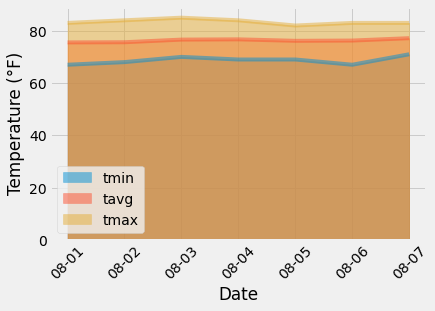

In [42]:
# Plot the daily normals as an area plot with `stacked=False`

date_df.plot.area(stacked=False, rot=45)
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')

## Close Session

In [43]:
session.close()
